# CSCI 4435/5435: Text Mining & Natural Language Processing
## Assignment 5: Using LLMs for Summarization (using tl;dr)
### Student: Miguel Guirao
### Aggie ID: 800699208

## Summary
0. Reference: [Amazon Review Summarization Using GPT-2 And PyTorch](https://www.nbshare.io/notebook/764386829/Amazon-Review-Summarization-Using-GPT-2-And-PyTorch/)
1. The news_summary dataset has two features and 98,401 examples. We will be using the "text" feature for training an LLM and "headlines" as True label.

In [1]:
# import the required libraries
import pandas as pd
import re
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, GPT2LMHeadModel
import torch.optim as optim
import transformers

In [2]:
# Check the versions I am using
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Transformers: {transformers.__version__}")

Pandas: 2.2.3
Numpy: 1.26.4
Transformers: 4.50.0


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using compute device: {device}")

Using compute device: cuda:0


### I mainly used the Amazon implementation as a reference, with the execption that I ploted a boxplot to determine the maximun lenght of the strings. The median is around 70 mand the maximun around 80 characters long. This lenght represents the length of the text plus the " TL;DR " token plus the headlines.
### I also added a news article from the NMSU web site (you can see it in cell #5) and generated sample headlines by the end of the notebook, in cell # 27.
### The training process took me around 35 minutes on an NVIDIA RTX A2000 12GB.

## 1. Load dataset

In [4]:
news_df = pd.read_csv('news_summary.csv')
news_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 1.1 Let's add one single article from the nmsu.edu web site. https://newsroom.nmsu.edu/news/nmsu-students--art-selected-for-public-spaces/s/63fccb18-5879-44f0-8d82-1eb4291d0e7d?cat=news|headlines-by-college

In [5]:
headlines = "NMSU students’ art selected for public spaces"
text = "Two New Mexico State University student artists, Yalet Yanar and Citlali Delgado, have been selected to showcase their work for Art Stop 2025. Their pieces, each with unique and powerful themes, will be displayed in public spaces across Las Cruces, bringing their artistic vision to the community. The event aims to showcase a range of creative expressions, offering the community an opportunity to engage with thought-provoking art in everyday spaces."
new_row = pd.DataFrame([{'headlines': headlines, 'text': text}])
news_df = pd.concat([news_df, new_row], ignore_index=True)
news_df.tail()

,headlines,text
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."
98401,NMSU students’ art selected for public spaces,Two New Mexico State University student artist...


## 2. Data Preprocessing

In [6]:
newssummary_df = news_df['text'] + " TL;DR " + news_df['headlines']
newssummary_df.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
dtype: object

In [7]:
print(newssummary_df[0])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. TL;DR upGrad learner switches to career in ML & Al with 90% salary hike


In [8]:
print(newssummary_df[98401])

Two New Mexico State University student artists, Yalet Yanar and Citlali Delgado, have been selected to showcase their work for Art Stop 2025. Their pieces, each with unique and powerful themes, will be displayed in public spaces across Las Cruces, bringing their artistic vision to the community. The event aims to showcase a range of creative expressions, offering the community an opportunity to engage with thought-provoking art in everyday spaces. TL;DR NMSU students’ art selected for public spaces


### In order to select a proper fixed length input, I get the lenghts of all reviews and create a boxplot. With the boxplot created I can easily see that the median input length is around 70 words, with a maximun of 80 words.
### I select 80 as the fixed length input.

In [9]:
newssummary_df_length = [len(review.split()) for review in newssummary_df] #/len(reviews)
print(min(newssummary_df_length), max(newssummary_df_length))

3 79


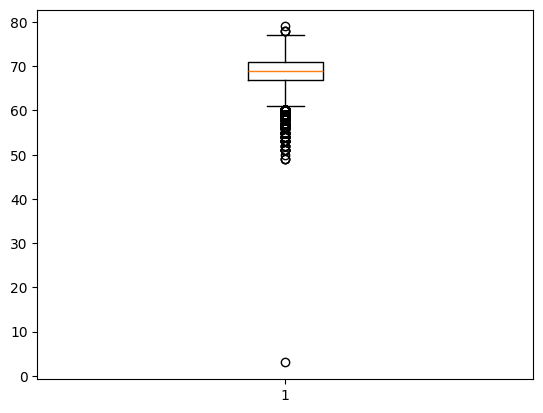

In [10]:
plt.boxplot(newssummary_df_length)
plt.show()

In [11]:
max_length = 80

## Setup and Training

In [12]:
# AutoModelForCausalLM: https://huggingface.co/docs/trl/main/en/models#trl.AutoModelForCausalLMWithValueHead
# AutoModelForMaskedLM: 
# https://huggingface.co/docs/transformers/main/en/model_doc/gpt2#transformers.GPT2LMHeadModel

In [13]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
#model = AutoModelWithLMHead.from_pretrained("gpt2") # Deprecated. Options: AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM
model = AutoModelForCausalLM.from_pretrained("gpt2")
model = model.to(device)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
model = model.to(device)

In [15]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

In [16]:
tokenizer.encode(" TL;DR ")

[24811, 26, 7707, 220]

In [17]:
extra_length = len(tokenizer.encode(" TL;DR ")) 

In [18]:
class ReviewDataset(Dataset):  
    def __init__(self, tokenizer, reviews, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.eos = self.tokenizer.eos_token
        self.eos_id = self.tokenizer.eos_token_id
        self.reviews = reviews
        self.result = []

        for review in self.reviews:
            # Encode the text using tokenizer.encode(). We add EOS at the end
            tokenized = self.tokenizer.encode(review + self.eos)
            
            # Padding/truncating the encoded sequence to max_len 
            padded = self.pad_truncate(tokenized)            

            # Creating a tensor and adding to the result
            self.result.append(torch.tensor(padded))

    def __len__(self):
        return len(self.result)


    def __getitem__(self, item):
        return self.result[item]

    def pad_truncate(self, name):
        name_length = len(name) - extra_length
        if name_length < self.max_len:
            difference = self.max_len - name_length
            result = name + [self.eos_id] * difference
        elif name_length > self.max_len:
            result = name[:self.max_len + 3]+[self.eos_id] 
        else:
            result = name
        return result

In [19]:
dataset = ReviewDataset(tokenizer, newssummary_df, max_length)

## (80 pts) Train a GPT model to perform summarization using tl;dr token.

In [20]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [21]:
def train(model, optimizer, dl, epochs):
    losses = []
    for epoch in range(epochs):
        for idx, batch in enumerate(dl):
             with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                batch = batch.to(device)
                output = model(batch, labels=batch)
                loss = output[0]
                loss.backward()
                losses.append(loss)
                optimizer.step()
                if idx % 50 == 0:
                    print("loss: %f, %d"%(loss, idx))
    return losses

In [22]:
start = time.time()
losses = train(model=model, optimizer=optimizer, dl=dataloader, epochs=1)
end = time.time()
print(f"Total training time: {(end-start):.3f} seconds.")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


loss: 3.551122, 0
loss: 3.097840, 50
loss: 2.905638, 100
loss: 2.861298, 150
loss: 2.805082, 200
loss: 2.802462, 250
loss: 2.820668, 300
loss: 2.817986, 350
loss: 2.701405, 400
loss: 2.758623, 450
loss: 2.813486, 500
loss: 2.771657, 550
loss: 2.748660, 600
loss: 2.832487, 650
loss: 2.737210, 700
loss: 2.762196, 750
loss: 2.840198, 800
loss: 2.799573, 850
loss: 2.793288, 900
loss: 2.858135, 950
loss: 2.578915, 1000
loss: 2.832851, 1050
loss: 2.604174, 1100
loss: 2.968117, 1150
loss: 2.687154, 1200
loss: 2.668963, 1250
loss: 2.643079, 1300
loss: 2.759460, 1350
loss: 2.641116, 1400
loss: 2.702096, 1450
loss: 2.722552, 1500
loss: 2.767593, 1550
loss: 2.615092, 1600
loss: 2.571893, 1650
loss: 2.680943, 1700
loss: 2.752356, 1750
loss: 2.607556, 1800
loss: 2.765063, 1850
loss: 2.722380, 1900
loss: 2.684078, 1950
loss: 2.733783, 2000
loss: 2.655906, 2050
loss: 2.601798, 2100
loss: 2.613528, 2150
loss: 2.618467, 2200
loss: 2.717565, 2250
loss: 2.652038, 2300
loss: 2.694995, 2350
loss: 2.634531,

## Review Summarization

In [23]:
def topk(probs, n=9):
    # The scores are initially softmaxed to convert to probabilities
    probs = torch.softmax(probs, dim= -1)
    
    # PyTorch has its own topk method, which we use here
    tokensProb, topIx = torch.topk(probs, k=n)
    
    # The new selection pool (9 choices) is normalized
    tokensProb = tokensProb / torch.sum(tokensProb)

    # Send to CPU for numpy handling
    tokensProb = tokensProb.cpu().detach().numpy()

    # Make a random choice from the pool based on the new prob distribution
    choice = np.random.choice(n, 1, p = tokensProb)
    tokenId = topIx[choice][0]

    return int(tokenId)

In [24]:
def model_infer(model, tokenizer, review, max_length=15):
    # Preprocess the init token (task designator)
    review_encoded = tokenizer.encode(review)
    result = review_encoded
    initial_input = torch.tensor(review_encoded).unsqueeze(0).to(device)

    with torch.set_grad_enabled(False):
        # Feed the init token to the model
        output = model(initial_input)

        # Flatten the logits at the final time step
        logits = output.logits[0,-1]

        # Make a top-k choice and append to the result
        result.append(topk(logits))

        # For max_length times:
        for _ in range(max_length):
            # Feed the current sequence to the model and make a choice
            input = torch.tensor(result).unsqueeze(0).to(device)
            output = model(input)
            logits = output.logits[0,-1]
            res_id = topk(logits)

            # If the chosen token is EOS, return the result
            if res_id == tokenizer.eos_token_id:
                return tokenizer.decode(result)
            else: # Append to the sequence 
                result.append(res_id)
    # IF no EOS is generated, return after the max_len
    return tokenizer.decode(result)

In [25]:
sample_reviews = [review.split(" TL;DR ")[0] for review in random.sample(newssummary_df.to_list(), 5)]
print(sample_reviews, len(sample_reviews))

["In a world where negative news is all around us, RPG has introduced Happiness Studios, a platform of positive stories. This is in line with the Group's tagline â\x80\x93 Hello Happiness. With this, RPG launches its Instagram handle where it will post real stories of courage and change, which enable progress, the truest embodiment of Happiness.", "Pakistani actress-singer Reshma has been shot dead by her husband in the country's Khyber Pakhtunkhwa province. Reshma, who was the accused's fourth wife, used to live with her brother. Reshma's husband along with an accomplice entered the house and opened fire on her, police said. This is reportedly this year's 15th incident of violence against female artists in Khyber Pakhtunkhwa.", "The Madhya Pradesh government has announced a â\x82¹50 lakh cash award for the Indian women's cricket team, which finished as runners-up after losing to England in the Women's Cricket World Cup final on Sunday. The state Chief Minister Shivraj Singh Chouhan tw

## (20 pts) Based on the trained models, write code to generate summarizations of some example news.

In [26]:
sample_nmsu_review = []
nmsu_review = newssummary_df.to_list()[98401]
sample_nmsu_review.append(nmsu_review.split(" TL;DR ")[0]) # list: 2
sample_nmsu_review # list: 1
sample_reviews.append(sample_nmsu_review[0])
print(sample_reviews, len(sample_reviews))

["In a world where negative news is all around us, RPG has introduced Happiness Studios, a platform of positive stories. This is in line with the Group's tagline â\x80\x93 Hello Happiness. With this, RPG launches its Instagram handle where it will post real stories of courage and change, which enable progress, the truest embodiment of Happiness.", "Pakistani actress-singer Reshma has been shot dead by her husband in the country's Khyber Pakhtunkhwa province. Reshma, who was the accused's fourth wife, used to live with her brother. Reshma's husband along with an accomplice entered the house and opened fire on her, police said. This is reportedly this year's 15th incident of violence against female artists in Khyber Pakhtunkhwa.", "The Madhya Pradesh government has announced a â\x82¹50 lakh cash award for the Indian women's cricket team, which finished as runners-up after losing to England in the Women's Cricket World Cup final on Sunday. The state Chief Minister Shivraj Singh Chouhan tw

In [27]:
for review in sample_reviews:
    summaries = set()
    print(review)
    while len(summaries) < 3:
        summary = model_infer(model, tokenizer, review + " TL;DR ").split(" TL;DR ")[1].strip()
        if summary not in summaries:
            summaries.add(summary)
    print("Summaries: "+ str(summaries) +"\n")

In a world where negative news is all around us, RPG has introduced Happiness Studios, a platform of positive stories. This is in line with the Group's tagline â Hello Happiness. With this, RPG launches its Instagram handle where it will post real stories of courage and change, which enable progress, the truest embodiment of Happiness.
Summaries: {'RPG launches platform of positive stories �', "RPG's platform for positive stories launched", 'RPG launches Happiness Studios to bring happiness'}

Pakistani actress-singer Reshma has been shot dead by her husband in the country's Khyber Pakhtunkhwa province. Reshma, who was the accused's fourth wife, used to live with her brother. Reshma's husband along with an accomplice entered the house and opened fire on her, police said. This is reportedly this year's 15th incident of violence against female artists in Khyber Pakhtunkhwa.
Summaries: {'Reshma shot dead by husband in Pakistan', 'Reshma killed with husband by husband in Pakhtunk', 'Resh

### I added an extra news article from the NMSU website, using the article title and a couple of paragraph from the news article itself. For some reasonm when I use the model to generate a corresponding Headline, I get Summaries: {'', 'TL;', '<|endoftext|>'}. This article is added to the original dataset since the very beginning as you can see at cell # 5. After that I use the new dataset to train the model.

In [28]:
for review in sample_nmsu_review:
    summaries = set()
    print(review)
    while len(summaries) < 3:
        summary = model_infer(model, tokenizer, review + " TL;DR ").split(" TL;DR ")[1].strip()
        if summary not in summaries:
            summaries.add(summary)
    print("Summaries: "+ str(summaries) +"\n")

Two New Mexico State University student artists, Yalet Yanar and Citlali Delgado, have been selected to showcase their work for Art Stop 2025. Their pieces, each with unique and powerful themes, will be displayed in public spaces across Las Cruces, bringing their artistic vision to the community. The event aims to showcase a range of creative expressions, offering the community an opportunity to engage with thought-provoking art in everyday spaces.
Summaries: {'2 students chosen to showcase work for Art Stop', '<|endoftext|>', 'Art Stop 2025 finalists selected for New Mexico'}



# The end!